# Preparation

# Check sequence

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")

sample = pd.read_excel('./426project_Train+test（Train 119360-120359，1000；test 120360-120479,120）.xlsx')
sample['close_log'] = np.log(sample.close)
test = pd.read_excel('./426project_test.xlsx')
train = sample.iloc[:1000,:]

def check_stationarity(data, alpha=0.05, print_detail=True):
    result = adfuller(data)
    is_stationary = True if result[1] <= alpha else False
    if print_detail:
        print('p-value: %f' % result[1])
    if is_stationary is True:
        print('The sequence is stationary!')
    else:
        print('The sequence is not stationary!')
train['close_log'] = np.log(train.close)
check_stationarity(train.close_log)

def acorr_test(data):
    if acorr_ljungbox(train.close_log)[1][0].round(6) ==0:
        print('The sequence is not a White-noise sequence!')
    else:
        print('The sequence is a White-noise sequence!')
acorr_test(train.close_log)

p-value: 0.046751
The sequence is stationary!
The sequence is not a White-noise sequence!


# 1. GARCH & ARCH

/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


RMSE of arch: 15.048106632130715


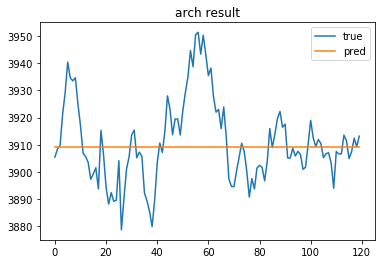

/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


RMSE of Garch: 17.01593696641463


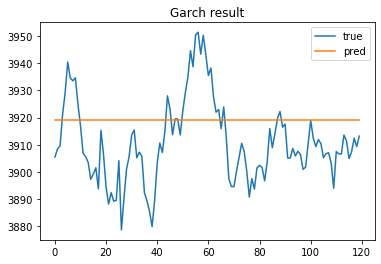

In [2]:
import arch
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

ar = arch.arch_model(sample.close_log[:1000], vol='arch', p=1, o=0, q=1, dist='Normal')
ar_fit = ar.fit(disp='off')
ar_pred = ar_fit.forecast(start=880,horizon=120)
print('RMSE of arch: {}'.format(np.sqrt(mean_squared_error(test.close, np.exp(ar_pred.mean['h.120'].dropna() - ar_pred.residual_variance['h.120'].dropna())))))
plt.figure()
plt.plot(np.array(test.close))
plt.plot(np.array(np.exp(ar_pred.mean['h.120'].dropna() - ar_pred.residual_variance['h.120'].dropna())))
plt.legend(['true','pred'])
plt.title('arch result')
plt.show()

gar = arch.arch_model(sample.close_log[:1000], vol='Garch', p=2, o=0, q=2, dist='Normal')
gar_fit = gar.fit(disp='off')
gar_pred = gar_fit.forecast(start=880,horizon=120)
print('RMSE of Garch: {}'.format(np.sqrt(mean_squared_error(test.close, np.exp(gar_pred.mean['h.120'].dropna() - gar_pred.residual_variance['h.120'].dropna())))))
plt.figure()
plt.plot(np.array(test.close))
plt.plot(np.array(np.exp(gar_pred.mean['h.120'].dropna() - gar_pred.residual_variance['h.120'].dropna())))
plt.legend(['true','pred'])
plt.title('Garch result')
plt.show()

# 2. ARIMA

(1, 0)
RMSE: 15.3163028278831


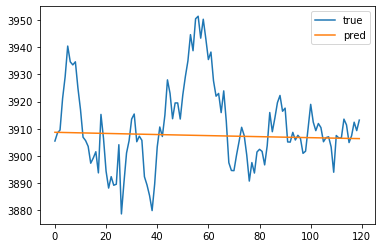

In [3]:
#模型定阶
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

order = st.arma_order_select_ic(sample.close_log[:1000], 5, 5, ic=['aic', 'bic', 'hqic'])
order = order.bic_min_order
print(order)
#建模
arma = ARMA(sample['close_log'][:1000],order).fit()

#样本外预测结果
print('RMSE: {}'.format(np.sqrt(mean_squared_error(np.exp(arma.forecast(steps=120)[0]), sample.close[-120:]))))
plt.figure()
plt.plot(np.array(sample.close[-120:]))
plt.plot(np.exp(arma.forecast(steps=120)[0]))
plt.legend(['true','pred'])
plt.show()

# 3. LSTM

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

scaler = MinMaxScaler()
dataset = scaler.fit_transform(np.array(sample['close']).reshape(-1,1))

def create_dataset(dataset, look_back=120):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

x_dataset, y_dataset = create_dataset(dataset)
x_train, trainY = x_dataset[:879], y_dataset[:879]

trainX = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

#训练模型
look_back=120
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = keras.callbacks.EarlyStopping(patience=5)
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, callbacks=[early_stop])

test_pred = model.predict(np.reshape(x_dataset, (x_dataset.shape[0], 1, x_dataset.shape[1]))[-120:])
test_pred = scaler.inverse_transform(test_pred)

Epoch 1/100
 - 3s - loss: 0.0089
Epoch 2/100
 - 2s - loss: 0.0034
Epoch 3/100
 - 2s - loss: 0.0030
Epoch 4/100
 - 2s - loss: 0.0024
Epoch 5/100
 - 2s - loss: 0.0022
Epoch 6/100
 - 2s - loss: 0.0020
Epoch 7/100
 - 2s - loss: 0.0020
Epoch 8/100
 - 2s - loss: 0.0018
Epoch 9/100
 - 2s - loss: 0.0016
Epoch 10/100
 - 2s - loss: 0.0014
Epoch 11/100
 - 2s - loss: 0.0016
Epoch 12/100
 - 2s - loss: 0.0014
Epoch 13/100
 - 2s - loss: 0.0014
Epoch 14/100
 - 2s - loss: 0.0013
Epoch 15/100
 - 2s - loss: 0.0013
Epoch 16/100
 - 2s - loss: 0.0011
Epoch 17/100
 - 2s - loss: 0.0011
Epoch 18/100
 - 2s - loss: 0.0013
Epoch 19/100
 - 2s - loss: 0.0013
Epoch 20/100
 - 2s - loss: 0.0012
Epoch 21/100
 - 2s - loss: 0.0011
Epoch 22/100
 - 2s - loss: 0.0012
Epoch 23/100
 - 2s - loss: 0.0012
Epoch 24/100
 - 2s - loss: 0.0012
Epoch 25/100
 - 2s - loss: 0.0012
Epoch 26/100
 - 2s - loss: 9.6895e-04
Epoch 27/100
 - 2s - loss: 0.0011
Epoch 28/100
 - 2s - loss: 9.7787e-04
Epoch 29/100
 - 2s - loss: 9.6535e-04
Epoch 30/10

RMSE: 11.049838720908248


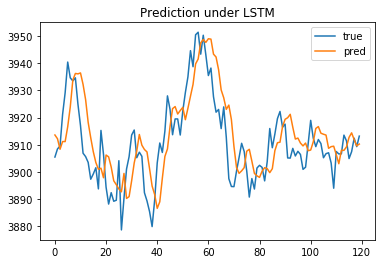

In [9]:
#预测结果对比
test_pred = test_pred[-120:]
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_pred, scaler.inverse_transform(dataset[-120:])))))
plt.figure()
plt.plot(scaler.inverse_transform(dataset[-120:]))
plt.plot(test_pred)
plt.legend(['true','pred'])
plt.title('Prediction under LSTM')
plt.show()

# 4. LSTM+Kalman filtering

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

Q = 0.00001
R = 0.1
P_k_k1 = 1
Kg = 0
P_k1_k1 = 1
x_k_k1 = 0
ADC_OLD_Value = 0
kalman_adc_old = 0

def kalman(ADC_Value):
    global kalman_adc_old
    global P_k1_k1
    Z_k = ADC_Value
    if (abs(kalman_adc_old-ADC_Value)>=30):
        x_k1_k1= ADC_Value*0.382 + kalman_adc_old*0.618
    else:
        x_k1_k1 = kalman_adc_old;
    x_k_k1 = x_k1_k1
    P_k_k1 = P_k1_k1 + Q
    Kg = P_k_k1/(P_k_k1 + R)
    kalman_adc = x_k_k1 + Kg * (Z_k - kalman_adc_old)
    P_k1_k1 = (1 - Kg)*P_k_k1
    P_k_k1 = P_k1_k1
    ADC_OLD_Value = ADC_Value
    kalman_adc_old = kalman_adc
    return kalman_adc

array = np.array(sample['close'])
adc=[]
for i in range(len(array)):
    adc.append(kalman(array[i]))
    
scaler = MinMaxScaler()
dataset = scaler.fit_transform(np.array(adc).reshape(-1,1))
train, test = dataset[:1000], dataset[1000:]

def create_dataset(dataset, look_back=120):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

x_dataset, y_dataset = create_dataset(dataset)
x_train, trainY = x_dataset[:879], y_dataset[:879]

trainX = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

#训练模型
look_back=120
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = keras.callbacks.EarlyStopping(patience=5)
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, callbacks=[early_stop])

test_pred = model.predict(np.reshape(x_dataset, (x_dataset.shape[0], 1, x_dataset.shape[1]))[-120:])
test_pred = scaler.inverse_transform(test_pred)

Epoch 1/100
 - 3s - loss: 0.0015
Epoch 2/100
 - 2s - loss: 3.2534e-04
Epoch 3/100
 - 2s - loss: 2.3154e-04
Epoch 4/100
 - 2s - loss: 1.7450e-04
Epoch 5/100
 - 2s - loss: 1.6104e-04
Epoch 6/100
 - 2s - loss: 1.4542e-04
Epoch 7/100
 - 2s - loss: 1.3130e-04
Epoch 8/100
 - 2s - loss: 1.3531e-04
Epoch 9/100
 - 2s - loss: 1.2014e-04
Epoch 10/100
 - 2s - loss: 1.1631e-04
Epoch 11/100
 - 2s - loss: 1.1254e-04
Epoch 12/100
 - 2s - loss: 1.1919e-04
Epoch 13/100
 - 2s - loss: 1.0663e-04
Epoch 14/100
 - 2s - loss: 1.1046e-04
Epoch 15/100
 - 2s - loss: 9.3676e-05
Epoch 16/100
 - 2s - loss: 9.4992e-05
Epoch 17/100
 - 2s - loss: 1.0333e-04
Epoch 18/100
 - 2s - loss: 7.8682e-05
Epoch 19/100
 - 2s - loss: 1.0591e-04
Epoch 20/100
 - 2s - loss: 8.6417e-05
Epoch 21/100
 - 2s - loss: 8.1596e-05
Epoch 22/100
 - 2s - loss: 8.0248e-05
Epoch 23/100
 - 2s - loss: 7.2996e-05
Epoch 24/100
 - 2s - loss: 7.3927e-05
Epoch 25/100
 - 2s - loss: 7.7916e-05
Epoch 26/100
 - 2s - loss: 6.9984e-05
Epoch 27/100
 - 2s - loss

RMSE: 17.60928399896756


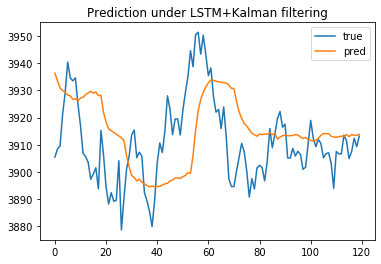

In [13]:
#预测结果对比
test_pred = test_pred[-120:]
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_pred, np.array(sample['close'][-120:])))))
plt.figure()
plt.plot(np.array(sample['close'][-120:]))
plt.plot(test_pred)
plt.legend(['true','pred'])
plt.title('Prediction under LSTM+Kalman filtering')
plt.show()

# 5. Regression

In [3]:
import numpy as np
from sklearn.linear_model import (LinearRegression, Ridge,Lasso)
#import matplotlib as mpl
#mpl.use('agg')
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import pandas as pd
dataset_train = pd.read_csv('train.csv')
training_set = dataset_train.iloc[:1000, 1:2].values
#test_set = dataset_train.iloc[1001:, 1:2].values
#print(len(training_set))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
#test_set_scaled = sc.fit_transform(test_set)
#print(training_set_scaled)
X_train = []
y_train = []
for i in range(120, 1000):
    X_train.append(training_set_scaled[i-120:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
clf=LinearRegression()
clf.fit(X_train, y_train)

dataset_test = pd.read_csv('test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values
dataset_total = pd.concat((dataset_train['open'], dataset_test['open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 120:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(120,240):
    X_test.append(inputs[i-120:i, 0])
X_test = np.array(X_test)
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = clf.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price.reshape(-1,1))
print('Regre model is done!')

Regre model is done!


The rmse of Regre model is 8.119373337039606


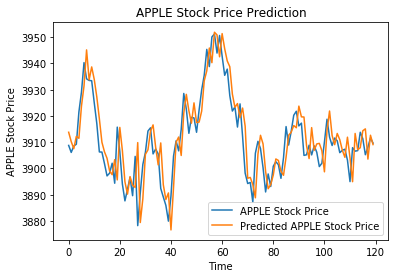

In [4]:
from sklearn.metrics import mean_squared_error
print('The rmse of Regre model is {}'.format(np.sqrt(mean_squared_error(real_stock_price,predicted_stock_price))))
plt.plot(real_stock_price, label = 'APPLE Stock Price')
plt.plot(predicted_stock_price,label = 'Predicted APPLE Stock Price')
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.show()

# 6. RNN

In [5]:
from keras.layers.recurrent import SimpleRNN
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import pandas as pd
#dataset_train = pd.read_csv('train.csv')
#training_set = dataset_train.iloc[:1000, 1:2].values
dataset_train = sample.iloc[:1000,:]
training_set = sample.iloc[:1000, 2:3].values

#test_set = dataset_train.iloc[1001:, 1:2].values
#print(len(training_set))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
#test_set_scaled = sc.fit_transform(test_set)
#print(training_set_scaled)
X_train = []
y_train = []
for i in range(120, 1000):
    X_train.append(training_set_scaled[i-120:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
regressor = Sequential()
regressor.add(SimpleRNN(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

#dataset_test = pd.read_csv('test.csv')
#real_stock_price = dataset_test.iloc[:, 1:2].values
dataset_test = sample.iloc[-120:,:]
real_stock_price = sample.iloc[-120:, 2:3].values

dataset_total = pd.concat((dataset_train['close'], dataset_test['close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 120:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(120,240):
    X_test.append(inputs[i-120:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

Epoch 1/50
880/880 [==============================] - 4s 5ms/step - loss: 0.5422
Epoch 2/50
880/880 [==============================] - 3s 3ms/step - loss: 0.3380
Epoch 3/50
880/880 [==============================] - 3s 3ms/step - loss: 0.2707
Epoch 4/50
880/880 [==============================] - 3s 3ms/step - loss: 0.2132
Epoch 5/50
880/880 [==============================] - 3s 3ms/step - loss: 0.1802
Epoch 6/50
880/880 [==============================] - 3s 3ms/step - loss: 0.1587
Epoch 7/50
880/880 [==============================] - 3s 3ms/step - loss: 0.1331
Epoch 8/50
880/880 [==============================] - 3s 3ms/step - loss: 0.1274
Epoch 9/50
880/880 [==============================] - 3s 3ms/step - loss: 0.1068
Epoch 10/50
880/880 [==============================] - 3s 3ms/step - loss: 0.0963
Epoch 11/50
880/880 [==============================] - 3s 3ms/step - loss: 0.0826
Epoch 12/50
880/880 [==============================] - 3s 3ms/step - loss: 0.0735
Epoch 13/50
880/880 [====

The rmse of RNN model is 34.07892494044887


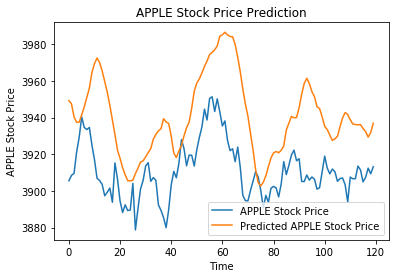

In [14]:
from sklearn.metrics import mean_squared_error
print('The rmse of RNN model is {}'.format(np.sqrt(mean_squared_error(real_stock_price,predicted_stock_price))))
plt.plot(real_stock_price, label = 'APPLE Stock Price')
plt.plot(predicted_stock_price, label = 'Predicted APPLE Stock Price')
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend(loc='best')
plt.show()